# Training file for RDN

## Imports

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision.transforms as transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
device = None
#import torch_directml #WINDOWS users
#device = torch_directml.device()
if not device:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from rdn import RDN
print(device)

cuda


# Utility function

In [2]:
class SuperResolutionStatsManager(nt.StatsManager):
    
    def __init__(self):
        super(SuperResolutionStatsManager, self).__init__()

    def init(self):
        super(SuperResolutionStatsManager, self).init()
        # Initializing `self.running_psnr`
        self.running_psnr = 0

    def accumulate(self, loss, x, y, d):
        super(SuperResolutionStatsManager, self).accumulate(loss, x, y, d)
        # Updating `self.running_psnr`
        self.running_psnr += 10*np.log10(4/torch.norm(y-d).detach().to('cpu').numpy()**2)
    
    def summarize(self):
        loss = super(SuperResolutionStatsManager, self).summarize()
        psnr = self.running_psnr / (self.number_update+1e-9 )
        return {'loss': loss, 'psnr': psnr}

def criterion(y, d):
    return F.mse_loss(y, d)

#show image
def myimshow(image, ax=plt):
    image = image.detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    # ax.axis('off')
    return h

## Data loader

In [3]:
new_img_size = 256
common_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    common_transform,
    #transforms.RandomRotation(degrees=10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    #transforms.RandomResizedCrop(size=(new_img_size, new_img_size), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
])

valid_transform = transforms.Compose([
    common_transform,
    #transforms.CenterCrop((new_img_size, new_img_size)),
])

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#import your datasetclass
from lowhighresimagedataset import LowAndHighResImageDataset

X_train = LowAndHighResImageDataset(transform=train_transform, train=True, onDevice=device)
X_valid = LowAndHighResImageDataset(transform=valid_transform, train=False, onDevice=device)
X_train.get_info()

#train_loader = DataLoader(X_train, batch_size=32, shuffle=True)
#valid_loader = DataLoader(X_valid, batch_size=32, shuffle=True)

Number of train low resolution images: 800
Number of train high resolution images: 800
Number of valid low resolution images: 200
Number of valid high resolution images: 200


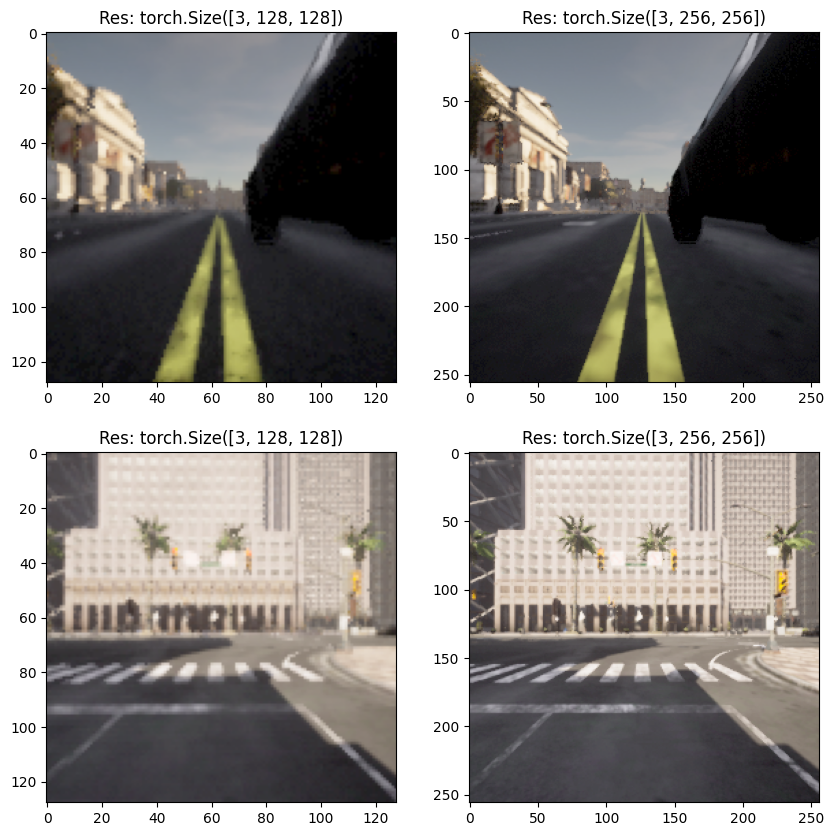

In [5]:
#printing some 2 pairs of low res/high res images
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ex_low_res1, ex_high_res1 = X_train[np.random.randint(len(X_train))]
ex_low_res2, ex_high_res2 = X_train[np.random.randint(len(X_train))]
ex = [ex_low_res1, ex_high_res1, ex_low_res2, ex_high_res2]
for i, ax in enumerate(axes.flat):
    ax.set_title(f'Res: {ex[i].shape}')
    myimshow(ex[i], ax=ax)

## Experiment

In [6]:
lr = 1e-3
B = 1
r = RDN(C=3 , D=10, G=64, G0=64, scaling_factor=2, kernel_size=3, c_dims=X_train[0][0].shape[0], upscaling='ups', weights=None)
r = r.to(device)
adam = torch.optim.Adam(r.parameters(), lr=lr)
stats_manager = SuperResolutionStatsManager()
exp1 = nt.Experiment(r, X_train, X_valid, adam, stats_manager, device, criterion, batch_size=B,
                     output_dir="superresol", perform_validation_during_training=False)

Start/Continue training from epoch 0
Epoch 1 (Time: 43.50s)
Epoch 2 (Time: 43.04s)
Finish training for 2 epochs


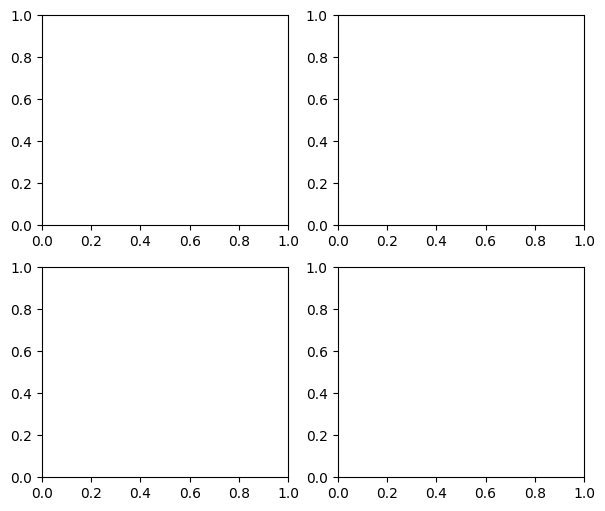

In [7]:
def plot(exp, fig, axes, low_res):
    with torch.no_grad():
        high_res = exp.net(low_res)
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(low_res, ax=axes[0][0])
    axes[0][0].set_title('Low resolution image')
    myimshow(high_res, ax=axes[0][1])
    axes[0][1].set_title('High resolution image')    
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="Train loss")
    axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)], label="Train psnr")
    axes[1][0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)], label="Eval loss")
    axes[1][1].plot([exp.history[k][1]['psnr'] for k in range(exp.epoch)], label="Eval psnr")
    axes[1][0].legend()
    axes[1][0].set_xlabel("Epoch")
    axes[1][0].set_ylabel("Loss")        
    axes[1][1].legend()
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("PSNR")    
    plt.tight_layout()
   
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6))
#exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes, low_res=X_valid[0][0]))
exp1.run(num_epochs=2, plot=None)